# Image Classification with ResNet18

This notebook implements an image classification model using transfer learning with ResNet18。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import time
import os
import platform
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import multiprocessing

## 1. Hardware Acceleration Configuration

## Configuration and Hardware Setup

This section configures the training parameters and automatically detects the best available hardware acceleration (CUDA GPU > Apple Silicon MPS > CPU). It also sets random seeds for reproducible results.

Key settings include:
- **Batch size**: Number of images processed simultaneously
- **Learning rate**: Step size for optimizer updates
- **Number of epochs**: Maximum training iterations
- **Early stopping patience**: Epochs to wait before stopping if no improvement
- **Dataset split**: 70% training, 15% validation, 15% testing

In [2]:
# Configuration settings
CONFIG = {
    'train_data_dir': '../Public_dataset',  # Full path to training data
    'test_data_dir': '../Public_dataset',   # Using same dataset; DataLoader will split into train/val
    'batch_size': 64,
    'num_epochs': 10,
    'learning_rate': 0.001,
    'num_classes': 3,  # Adjust based on your classes (aluminium, paper, plastic)
    'early_stop_patience': 5,
    'train_val_split': 0.8,  # 80% train, 20% val
}

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 自动检测设备优先级: CUDA > MPS > CPU
if torch.cuda.is_available():
    CONFIG['device'] = torch.device("cuda")
    print(f"🚀 Success! Using CUDA GPU acceleration.")
elif torch.backends.mps.is_available():
    CONFIG['device'] = torch.device("mps")
    print(f"🚀 Success! Using Apple M4 GPU (MPS) acceleration.")
else:
    CONFIG['device'] = torch.device("cpu")
    print("⚠️ Warning: No GPU available. Using CPU (Slower).")

🚀 Success! Using CUDA GPU acceleration.


## 2. Data Preprocessing and Loading

## Data Preprocessing and Loading Pipeline

This section handles the complete data preparation pipeline:

### Data Cleaning (Parallel Processing)
- **Purpose**: Remove corrupted images and ensure consistent format
- **Process**: Scans all image files, converts non-RGB images to RGB, deletes unreadable files
- **Parallel execution**: Uses multiple CPU cores for faster processing on large datasets

### Data Augmentation and Transforms
- **Training transforms**: Includes random flips, rotations, color jittering, and affine transformations to prevent overfitting
- **Validation/Test transforms**: Only basic resizing and normalization for consistent evaluation

### Dataset Splitting and Loading
- **Stratified split**: 70% training, 15% validation, 15% testing to ensure balanced evaluation
- **DataLoader optimization**: Configured with multiple workers and pinned memory for GPU acceleration

In [3]:
# import os
# import shutil
# import random
# from pathlib import Path

# # =================配置区域=================
# # 你的原始解压路径
# SOURCE_DIR = './' 

# # 你的目标路径 (ResNet 代码要读取的路径)
# TARGET_DIR = './Dataset_Assigned' 

# # 验证集比例 (20%)
# VAL_RATIO = 0.2
# # =========================================

# def reorganize_dataset():
#     if not os.path.exists(SOURCE_DIR):
#         print(f"❌ Error: Source directory '{SOURCE_DIR}' not found!")
#         return

#     print(f"🚀 Starting dataset reorganization...")
#     print(f"   From: {SOURCE_DIR}")
#     print(f"   To:   {TARGET_DIR}")

#     # 获取所有类别 (排除 json 文件和隐藏文件)
#     classes = [d for d in os.listdir(SOURCE_DIR) 
#                if os.path.isdir(os.path.join(SOURCE_DIR, d)) and not d.startswith('.')]
    
#     print(f"   Found {len(classes)} classes: {classes}")

#     # 创建 train 和 val 根目录
#     for split in ['train', 'val']:
#         os.makedirs(os.path.join(TARGET_DIR, split), exist_ok=True)

#     for class_name in classes:
#         # 源类别路径
#         src_class_dir = os.path.join(SOURCE_DIR, class_name)
        
#         # 获取该类别下所有图片
#         images = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
#         # 随机打乱
#         random.shuffle(images)
        
#         # 计算切分点
#         split_idx = int(len(images) * (1 - VAL_RATIO))
#         train_imgs = images[:split_idx]
#         val_imgs = images[split_idx:]
        
#         print(f"   Processing {class_name}: {len(train_imgs)} Train, {len(val_imgs)} Val")
        
#         # 移动 (或复制) 到目标文件夹
#         # 这里用 copy (复制)，保留原文件以防万一
        
#         # 1. 处理 Train
#         dst_train_dir = os.path.join(TARGET_DIR, 'train', class_name)
#         os.makedirs(dst_train_dir, exist_ok=True)
#         for img in train_imgs:
#             shutil.copy(os.path.join(src_class_dir, img), os.path.join(dst_train_dir, img))
            
#         # 2. 处理 Val
#         dst_val_dir = os.path.join(TARGET_DIR, 'val', class_name)
#         os.makedirs(dst_val_dir, exist_ok=True)
#         for img in val_imgs:
#             shutil.copy(os.path.join(src_class_dir, img), os.path.join(dst_val_dir, img))

#     print("\n✅ Dataset Reorganization Complete!")
#     print(f"📂 You can now set CONFIG['data_dir'] = '{TARGET_DIR}' in your main code.")

# if __name__ == '__main__':
#     reorganize_dataset()

In [4]:
# 0. 数据清洗 (防爆盾牌) - 放在最前面跑一次 [PARALLEL VERSION]

def process_single_file(file_info):
    """Process a single file (used for parallel processing)"""
    file_path, valid_extensions = file_info
    file = os.path.basename(file_path)
    
    result = {'converted': 0, 'deleted': 0, 'warning': None}
    
    # 1. 删除非图片文件
    if not file.lower().endswith(valid_extensions):
        if not file.startswith('.'):
            result['warning'] = f"⚠️ Non-image file found: {file}"
        return result
    
    # 2. 检查图片能否打开 & 强制转为 RGB
    try:
        with Image.open(file_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
                img.save(file_path)
                result['converted'] = 1
    except Exception as e:
        result['warning'] = f"❌ Corrupted file found and removed: {file_path} ({e})"
        try:
            os.remove(file_path)
            result['deleted'] = 1
        except:
            pass
    
    return result

def clean_and_verify_data(root_dir, max_workers=None):
    """Parallel version of data cleaning using ThreadPoolExecutor"""
    print(f"🧹 Scanning and cleaning dataset at: {root_dir} ...")
    
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    file_list = []

    # 1. Collect all file paths
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            file_list.append((file_path, valid_extensions))

    print(f"📁 Found {len(file_list)} files to process")
    
    if max_workers is None:
        max_workers = min(32, (multiprocessing.cpu_count() or 1) + 4)
    print(f"⚡ Using parallel processing with {max_workers} workers")

    deleted_count = 0
    converted_count = 0

    # 2. Process in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_single_file, file_info) for file_info in file_list]
        
        for future in as_completed(futures):
            result = future.result()
            if result['warning']:
                print(result['warning'])
            deleted_count += result['deleted']
            converted_count += result['converted']

    print(f"✅ Data cleaning complete!")
    print(f"   - Deleted/Corrupted: {deleted_count}")
    print(f"   - Converted to RGB: {converted_count}")

# Run cleaning on both datasets
clean_and_verify_data(CONFIG['train_data_dir'])
clean_and_verify_data(CONFIG['test_data_dir'])

🧹 Scanning and cleaning dataset at: ../Public_dataset ...
📁 Found 2684 files to process
⚡ Using parallel processing with 16 workers
✅ Data cleaning complete!
   - Deleted/Corrupted: 0
   - Converted to RGB: 0
🧹 Scanning and cleaning dataset at: ../Public_dataset ...
📁 Found 2684 files to process
⚡ Using parallel processing with 16 workers
✅ Data cleaning complete!
   - Deleted/Corrupted: 0
   - Converted to RGB: 0


In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Standard ResNet18 input size
        transforms.RandomHorizontalFlip(),  # Data augmentation: horizontal mirroring
        transforms.RandomRotation(15),  # Data augmentation: random rotation ±15 degrees
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Color augmentation
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Geometric augmentation
        transforms.ToTensor(),  # Convert PIL images to tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),  # Consistent size for evaluation
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Same normalization as training
    ]),
}

# Load dataset and create stratified train/val/test splits
try:
    full_dataset = datasets.ImageFolder(CONFIG['train_data_dir'])  # Load images from folder structure
    
    # Extract class names from folder structure
    class_names = full_dataset.classes
    print(f"✅ Classes found: {class_names}")
    
    # Auto-correct num_classes if it doesn't match detected classes
    if len(class_names) != CONFIG['num_classes']:
        print(f"⚠️ WARNING: You set num_classes={CONFIG['num_classes']}, but found {len(class_names)} classes!")
        CONFIG['num_classes'] = len(class_names)  # Auto-correct
    
    # Create reproducible stratified splits: 70% train, 15% val, 15% test
    total_size = len(full_dataset)
    train_size = int(total_size * 0.7)
    val_size = int(total_size * 0.15)
    test_size = total_size - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size], 
        generator=torch.Generator().manual_seed(42)  # Reproducible splits
    )
    
    # Apply appropriate transforms to each split
    train_dataset.dataset.transform = data_transforms['train']
    val_dataset.dataset.transform = data_transforms['val']
    test_dataset.dataset.transform = data_transforms['val']  # Test uses same transforms as validation
    
    # Configure DataLoader with performance optimizations
    num_workers = 4  # Parallel data loading workers
    use_pin_memory = CONFIG.get('device', torch.device('cpu')).type in ['cuda', 'mps']  # GPU memory pinning
    
    dataloaders = {
        'train': DataLoader(
            train_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=True,  # Shuffle training data
            num_workers=num_workers,
            pin_memory=use_pin_memory,  # Faster GPU transfers
            persistent_workers=(num_workers > 0)  # Keep workers alive between epochs
        ),
        'val': DataLoader(
            val_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=False,  # No shuffling for validation
            num_workers=num_workers,
            pin_memory=use_pin_memory,
            persistent_workers=(num_workers > 0)
        ),
        'test': DataLoader(
            test_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=False,  # No shuffling for testing
            num_workers=num_workers,
            pin_memory=use_pin_memory,
            persistent_workers=(num_workers > 0)
        )
    }
    
    # Store dataset sizes for logging
    dataset_sizes = {'train': train_size, 'val': val_size, 'test': test_size}
    print(f"✅ Dataset split: Train={train_size}, Val={val_size}, Test={test_size}")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Please ensure your data is in: ./Public_dataset/class1/, ./Public_dataset/class2/, etc.")
    import traceback
    traceback.print_exc()

✅ Classes found: ['aluminium', 'paper', 'plastic']
✅ Dataset split: Train=1878, Val=402, Test=404


## 3. Model Definition (ResNet18 with Transfer Learning)

This section implements transfer learning using a pre-trained ResNet18 model:

### Transfer Learning Strategy
- **Pre-trained weights**: Uses ImageNet-trained ResNet18 for feature extraction
- **Frozen layers**: All convolutional layers are frozen to preserve learned features
- **Custom classifier**: Replaces the final fully connected layer with a custom head
- **Regularization**: Adds dropout (50%) to prevent overfitting on the new classification task

### Model Components
- **Backbone**: ResNet18 feature extractor (512-dimensional output)
- **Classifier head**: Dropout → Linear layer (512 → num_classes)
- **Loss function**: Cross-entropy loss for multi-class classification
- **Optimizer**: Adam optimizer for efficient gradient updates

In [6]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Load pre-trained ResNet18

# Freeze all layers except the final classifier to preserve learned features
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer with custom architecture
num_ftrs = model.fc.in_features  # Get input features from ResNet18 (512)
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout for regularization to prevent overfitting
    nn.Linear(num_ftrs, CONFIG['num_classes'])  # Final classification layer
)

# Move model to the detected device (GPU/CPU)
model = model.to(CONFIG['device'])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Standard loss for multi-class classification
optimizer = optim.Adam(model.fc.parameters(), lr=CONFIG['learning_rate'])  # Only optimize classifier parameters

## 4. Training Function

## Training Loop with Advanced Features

This section implements a comprehensive training pipeline with multiple optimization techniques:

### Training Features
- **Mixed Precision Training**: Uses automatic mixed precision (AMP) on CUDA GPUs for 1.5-2x speedup and memory efficiency
- **Early Stopping**: Monitors validation accuracy and stops training if no improvement for specified epochs
- **Progress Monitoring**: Displays batch-level and epoch-level metrics during training
- **Best Model Checkpointing**: Automatically saves the model weights with best validation performance

### Training Process
1. **Epoch Loop**: Iterates through specified number of epochs
2. **Phase Loop**: Alternates between training and validation phases
3. **Batch Processing**: Processes data in batches with GPU acceleration
4. **Metrics Calculation**: Computes loss and accuracy for each batch and epoch
5. **Early Stopping Check**: Evaluates validation performance and triggers early stopping if needed

### Memory Management
- **CUDA Cache Clearing**: Automatically clears GPU memory before and after training
- **Memory Monitoring**: Displays GPU memory usage information when available

In [7]:
def train_model(model, criterion, optimizer, num_epochs=5, patience=3):
    """
    Comprehensive training function with early stopping, mixed precision, and progress tracking.
    
    Args:
        model: PyTorch model to train
        criterion: Loss function
        optimizer: Optimizer for parameter updates
        num_epochs: Maximum number of training epochs
        patience: Number of epochs to wait for improvement before early stopping
    
    Returns:
        model: Trained model with best weights loaded
        history: Dictionary containing training/validation metrics per epoch
    """
    since = time.time()
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    
    # Early stopping initialization
    best_val_acc = 0.0
    best_model_wts = None
    patience_counter = 0

    # Mixed precision training setup (only for CUDA GPUs)
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    
    # Clear GPU cache before training to ensure clean memory state
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        print(f'\n{"="*60}')
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'{"="*60}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Enable dropout and batch normalization updates
                print(f'\n🔄 Training Phase')
            else:
                model.eval()   # Disable dropout and use running stats for batch norm
                print(f'\n✅ Validation Phase')

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            batch_count = 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                # Move data to the appropriate device (GPU/CPU)
                inputs = inputs.to(CONFIG['device'])
                labels = labels.to(CONFIG['device'])

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if scaler and phase == 'train':  # Mixed precision training for CUDA
                        with torch.cuda.amp.autocast():
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)
                        # Scale loss and backpropagate
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                    else:  # Standard precision training
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                # Accumulate metrics across batches
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)
                batch_count += 1
                
                # Progress reporting every 5 batches
                if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
                    batch_acc = torch.sum(preds == labels.data).float() / inputs.size(0)
                    batch_loss = loss.item()
                    print(f'  Batch [{batch_idx+1}/{len(dataloaders[phase])}] | '
                          f'Loss: {batch_loss:.4f} | Acc: {batch_acc:.4f}')

            # Calculate epoch-level metrics
            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.float() / total_samples

            print(f'\n{phase.upper()} Results:')
            print(f'  Loss: {epoch_loss:.4f}')
            print(f'  Accuracy: {epoch_acc:.4f}')
            print(f'  Total Samples: {total_samples}')
            
            # Store metrics in history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Early stopping logic based on validation accuracy
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = model.state_dict().copy()
                    patience_counter = 0
                    print(f'\n✅ New best model! Val Acc: {best_val_acc:.4f}')
                else:
                    patience_counter += 1
                    print(f'\n⏳ No improvement for {patience_counter}/{patience} epochs')
                    
                    if patience_counter >= patience:
                        print(f'\n{"="*60}')
                        print(f'🛑 Early Stopping triggered!')
                        print(f'   Best Val Acc: {best_val_acc:.4f}')
                        print(f'   Stopped at Epoch {epoch+1}/{num_epochs}')
                        print(f'{"="*60}')
                        model.load_state_dict(best_model_wts)
                        time_elapsed = time.time() - since
                        print(f'⏱️  Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
                        return model, history

    # Load best model weights if training completed without early stopping
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        print(f'\n{"="*60}')
        print(f'✅ Training finished!')
        print(f'   Best Val Acc: {best_val_acc:.4f}')
        print(f'{"="*60}')
    
    time_elapsed = time.time() - since
    print(f'⏱️  Total training time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    # Clean up GPU memory after training
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("🧹 CUDA cache cleared after training")
    
    return model, history

In [8]:
# 如果数据加载成功，开始训练
if 'dataloaders' in locals():
    print(f"\n{'='*60}")
    print(f"🚀 Starting ResNet18 Training")
    print(f"{'='*60}")
    print(f"Device: {CONFIG['device']}")
    print(f"Classes: {class_names}")
    print(f"Batch Size: {CONFIG['batch_size']}")
    print(f"Learning Rate: {CONFIG['learning_rate']}")
    print(f"Max Epochs: {CONFIG['num_epochs']}")
    print(f"Early Stop Patience: {CONFIG['early_stop_patience']}")
    print(f"{'='*60}\n")
    
    trained_model, history = train_model(
        model, 
        criterion, 
        optimizer, 
        num_epochs=CONFIG['num_epochs'],
        patience=CONFIG['early_stop_patience']
    )
else:
    print("❌ Data not loaded. Please check the dataset path.")


🚀 Starting ResNet18 Training
Device: cuda
Classes: ['aluminium', 'paper', 'plastic']
Batch Size: 64
Learning Rate: 0.001
Max Epochs: 10
Early Stop Patience: 5


Epoch 1/10

🔄 Training Phase


/tmp/ipykernel_96872/42789932.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
/tmp/ipykernel_96872/42789932.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch [1/30] | Loss: 1.2653 | Acc: 0.3750
  Batch [5/30] | Loss: 1.2515 | Acc: 0.4375
  Batch [10/30] | Loss: 0.9923 | Acc: 0.4844
  Batch [15/30] | Loss: 0.9476 | Acc: 0.5781
  Batch [20/30] | Loss: 0.7334 | Acc: 0.6562
  Batch [25/30] | Loss: 0.8354 | Acc: 0.5938
  Batch [30/30] | Loss: 0.5672 | Acc: 0.8636

TRAIN Results:
  Loss: 0.9617
  Accuracy: 0.5527
  Total Samples: 1878

✅ Validation Phase
  Batch [1/7] | Loss: 0.6668 | Acc: 0.8125
  Batch [5/7] | Loss: 0.6825 | Acc: 0.7500

VAL Results:
  Loss: 0.6609
  Accuracy: 0.7637
  Total Samples: 402

✅ New best model! Val Acc: 0.7637

Epoch 2/10

🔄 Training Phase
  Batch [1/30] | Loss: 0.6962 | Acc: 0.6562
  Batch [5/30] | Loss: 0.8856 | Acc: 0.6250
  Batch [10/30] | Loss: 0.5927 | Acc: 0.7344
  Batch [15/30] | Loss: 0.7929 | Acc: 0.7031
  Batch [20/30] | Loss: 0.5398 | Acc: 0.7969
  Batch [25/30] | Loss: 0.5730 | Acc: 0.7969
  Batch [30/30] | Loss: 0.3119 | Acc: 0.9091

TRAIN Results:
  Loss: 0.6168
  Accuracy: 0.7513
  Total Samp

In [9]:
# CUDA Memory Monitoring (if using CUDA)
if torch.cuda.is_available():
    print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB total")
    print(f"CUDA Memory Available: {torch.cuda.mem_get_info()[0] / 1024**3:.1f} GB")
    torch.cuda.empty_cache()  # Clear any existing cache

CUDA Memory: 8.0 GB total
CUDA Memory Available: 5.2 GB


In [10]:
# Save the trained model
if 'trained_model' in locals():
    # Option 1: Save only model weights (lightweight, for inference only)
    model_save_path = 'resnet18_waste_classifier.pth'
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"✅ Model weights saved to '{model_save_path}' (for inference)")
    
    # Option 2: Save full model info (includes config, classes, history for reproducibility)
    model_info = {
        'model_state_dict': trained_model.state_dict(),
        'class_names': class_names,
        'config': CONFIG,
        'best_val_acc': max(history['val_acc']) if 'history' in locals() else None,
        'training_history': history if 'history' in locals() else None
    }
    full_save_path = 'resnet18_waste_classifier_full.pth'
    torch.save(model_info, full_save_path)
    print(f"✅ Full model info saved to '{full_save_path}' (for complete reproducibility)")
    
    print("\n📋 File Differences:")
    print("   - .pth (weights only): Smaller file, for deployment/inference")
    print("   - _full.pth (complete): Larger file, includes config/classes/history")
else:
    print("❌ No trained model to save.")

✅ Model weights saved to 'resnet18_waste_classifier.pth' (for inference)
✅ Full model info saved to 'resnet18_waste_classifier_full.pth' (for complete reproducibility)

📋 File Differences:
   - .pth (weights only): Smaller file, for deployment/inference
   - _full.pth (complete): Larger file, includes config/classes/history


## 6. Visualize Training Results

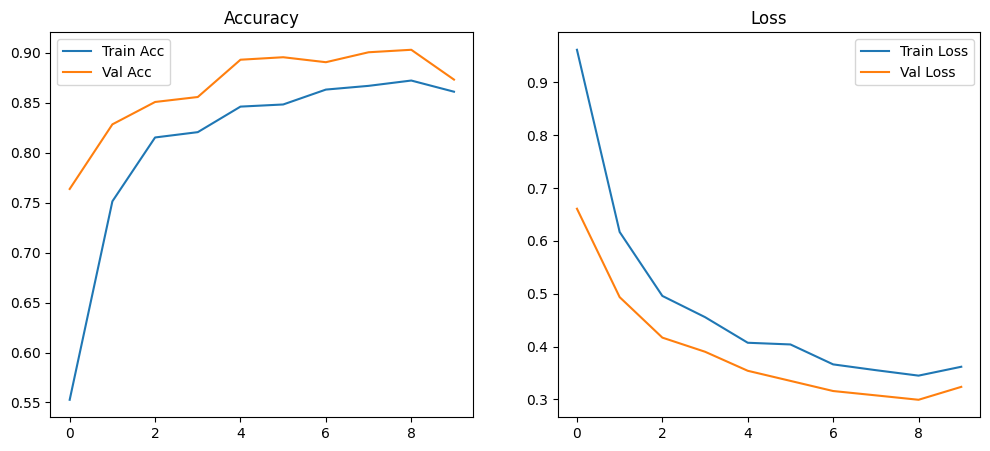

In [11]:
if 'history' in locals():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
else:
    print("❌ No training history available.")

## 7. Confusion Matrix and Classification Report

## Model Evaluation and Performance Analysis

This section provides comprehensive evaluation of the trained model on both validation and test sets:

### Evaluation Metrics
- **Confusion Matrix**: Visual heatmap showing prediction accuracy across all classes
- **Classification Report**: Detailed per-class metrics (precision, recall, F1-score)
- **Overall Accuracy**: Aggregate performance across all predictions
- **Training History**: Visualization of loss and accuracy curves over training epochs

### Evaluation Process
1. **Model Loading**: Loads the best-performing model weights
2. **Inference**: Runs predictions on validation and test sets without gradient computation
3. **Metrics Calculation**: Computes confusion matrix and classification metrics
4. **Visualization**: Creates heatmaps and plots for result interpretation
5. **Results Export**: Saves detailed predictions to CSV files for further analysis

### Output Files
- **predictions_val.csv**: Validation set predictions with true and predicted labels
- **predictions_test.csv**: Test set predictions with true and predicted labels
- **Model files**: Both lightweight (.pth) and full checkpoint (.pth) versions


📊 Evaluating on VAL set


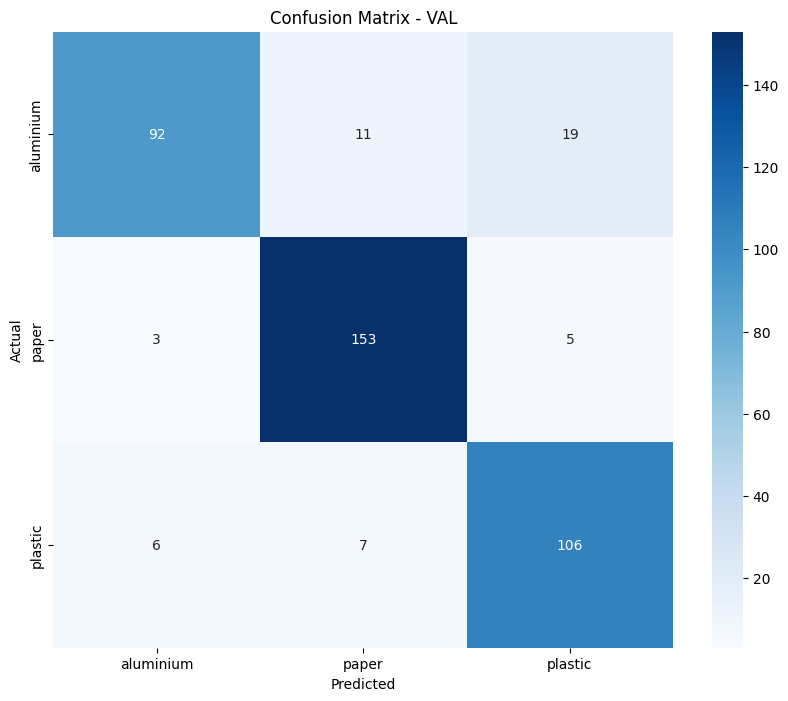


Classification Report (VAL):

              precision    recall  f1-score   support

   aluminium       0.91      0.75      0.83       122
       paper       0.89      0.95      0.92       161
     plastic       0.82      0.89      0.85       119

    accuracy                           0.87       402
   macro avg       0.87      0.87      0.87       402
weighted avg       0.88      0.87      0.87       402

Overall VAL Accuracy: 0.8731
✅ Predictions saved to 'predictions_val.csv'

📊 Evaluating on TEST set


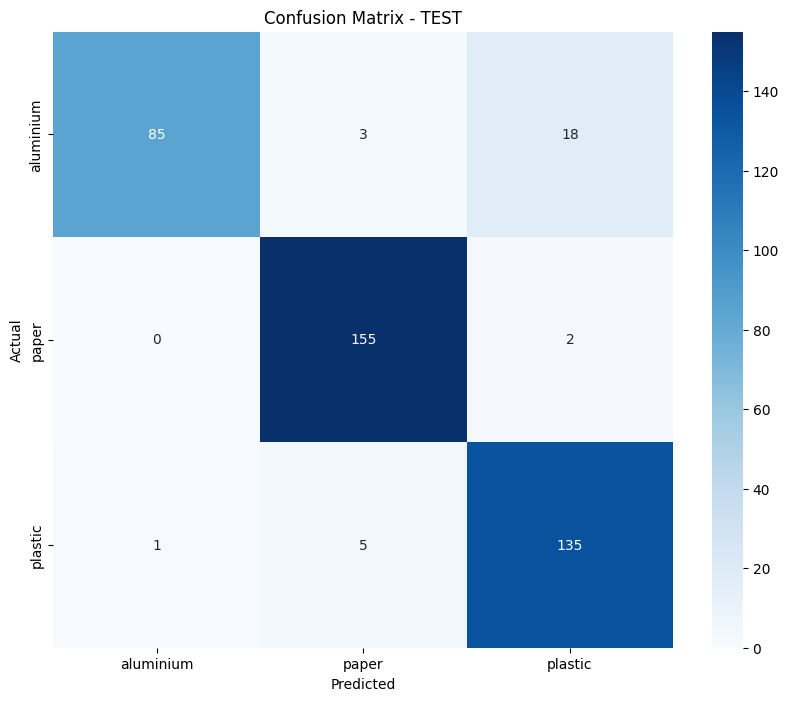


Classification Report (TEST):

              precision    recall  f1-score   support

   aluminium       0.99      0.80      0.89       106
       paper       0.95      0.99      0.97       157
     plastic       0.87      0.96      0.91       141

    accuracy                           0.93       404
   macro avg       0.94      0.92      0.92       404
weighted avg       0.93      0.93      0.93       404

Overall TEST Accuracy: 0.9282
✅ Predictions saved to 'predictions_test.csv'


In [12]:
# Evaluate on both validation and test sets
if 'trained_model' in locals() and 'dataloaders' in locals():
    for phase in ['val', 'test']:
        print(f"\n{'='*60}")
        print(f"📊 Evaluating on {phase.upper()} set")
        print(f"{'='*60}")
        
        all_preds = []
        all_labels = []
        all_filenames = []  # Collect sample identifiers for CSV export
        
        trained_model.eval()  # Set model to evaluation mode (disables dropout/batch norm updates)
        with torch.no_grad():  # Disable gradient computation for inference
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(CONFIG['device'])
                outputs = trained_model(inputs)
                _, preds = torch.max(outputs, 1)  # Get predicted class indices
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Generate sample identifiers since DataLoader doesn't provide original filenames
                batch_size = inputs.size(0)
                start_idx = len(all_filenames)
                all_filenames.extend([f"{phase}_sample_{start_idx + i}" for i in range(batch_size)])

        # Generate confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title(f'Confusion Matrix - {phase.upper()}')
        plt.show()
        
        # Generate detailed classification report
        print(f"\nClassification Report ({phase.upper()}):\n")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Calculate overall accuracy
        accuracy = np.trace(cm) / np.sum(cm)
        print(f"Overall {phase.upper()} Accuracy: {accuracy:.4f}")
        
        # Export predictions to CSV for further analysis
        import pandas as pd
        df_predictions = pd.DataFrame({
            'filename': all_filenames,  # Sample identifiers
            'true_label': [class_names[label] for label in all_labels],
            'predicted_label': [class_names[pred] for pred in all_preds]
        })
        df_predictions.to_csv(f'predictions_{phase}.csv', index=False)
        print(f"✅ Predictions saved to 'predictions_{phase}.csv'")
else:
    print("❌ Model not trained or data not loaded.")

In [13]:
# Note: Predictions are already saved in the evaluation cell above
# This duplicate cell has been removed to avoid errors